# Ants model analyses

_Copyright (C) 2023-, Joseph T. Lizier._
_Distributed under GNU General Public License v3_

This notebook template sets up reading in the data files for the Ants model simulations.

First code block is just to start up the JVM. You may need to change your paths below (use the AutoAnalyser to show them for you):

In [1]:
from jpype import *
import numpy
import sys
# Our python data file readers are a bit of a hack, python users will do better on this:
sys.path.append("../../../demos/python/")
import readFloatsFile

if (not isJVMStarted()):
    # Add JIDT jar library to the path
    jarLocation = "../../../infodynamics.jar"
    # Start the JVM (add the "-Xmx" option with say 1024M if you get crashes due to not enough memory space)
    startJVM(getDefaultJVMPath(), "-ea", "-Djava.class.path=" + jarLocation, convertStrings=True)

Next load in the sample data file and check that we can plot the ants positions ok.

Make sure that you have either downloaded the sample data ([positionsx.txt](https://github.com/jlizier/jidt-cc-extras/raw/main/course/Module08-InfoTheoryAndSelfOrganisation/Ants/positionsx.txt), [positionsy.txt](https://github.com/jlizier/jidt-cc-extras/raw/main/course/Module08-InfoTheoryAndSelfOrganisation/Ants/positionsy.txt) and [headings.txt](https://raw.githubusercontent.com/jlizier/jidt-cc-extras/main/course/Module08-InfoTheoryAndSelfOrganisation/Ants/headings.txt)) to the current folder or generated sample data.


IntProgress(value=0, max=300)

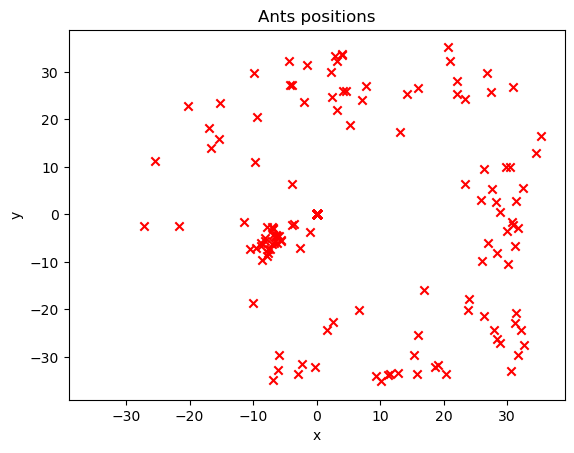

In [2]:
# 0. Load/prepare the data:
positionsx = readFloatsFile.readFloatsFile("./positionsx.txt")
positionsy = readFloatsFile.readFloatsFile("./positionsy.txt")
headings = readFloatsFile.readFloatsFile("./headings.txt")
# As numpy arrays:
positionsx = numpy.array(positionsx)
positionsy = numpy.array(positionsy)
headings = numpy.array(headings)

# Plot a sample of the ants moving:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from ipywidgets import IntProgress
from IPython.display import display
fig, ax = plt.subplots()
plots = []
timeStepsForPlot = min(positionsx.shape[0], 300)
f = IntProgress(min=0, max=timeStepsForPlot) # instantiate the progress bar
display(f) # display progress bar
for t in range(timeStepsForPlot):
    im = ax.scatter(positionsx[t,:], positionsy[t,:], marker='x', color='r', animated=True)
    if (t == 0):
         ax.scatter(positionsx[t,:], positionsy[t,:], marker='x', color='r')  # show an initial one first
    # If you want to keep the plots to make a video:
    plots.append([im])
    # To save a png of each plot as you go, uncomment the following:
    # plt.savefig('image-%03d.png' % t);
    f.value += 1 # update progress bar
plt.title('Ants positions');
plt.xlabel('x');
plt.ylabel('y');
# And put the animations into a short video:
ani = animation.ArtistAnimation(fig, plots, interval=100, blit=True,
                                repeat_delay=1000)
videoFilename = 'Ants-sample-video.mp4';
ani.save(videoFilename)
from IPython.display import Video
Video(videoFilename)

# Analysis 1 -- diversity of heading versus time

This sample analysis looks at how the diversity (measured by entropy) in the positions of each ant changes across time.

You can see that the diversity drops when the ants are making trails, with the largest 3 drops corresponding to when the trails to each food source are being sustained.

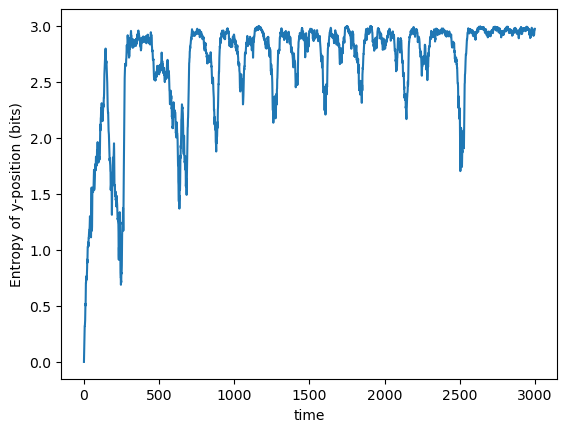

In [3]:
# 0. Load/prepare the data:
dataRaw = readFloatsFile.readFloatsFile("./positionsy.txt")
# As numpy array:
data = numpy.array(dataRaw)
# Transpose so that we have a column for each time step.
# This is different to our usual approach of each ant being a variable in a column.
data = data.T;

mUtils = JPackage('infodynamics.utils').MatrixUtils

# 1. Construct the calculator:
calcClass = JPackage("infodynamics.measures.discrete").EntropyCalculatorDiscrete
calc = calcClass(8) # Using 8 discrete bins
# 2. No other properties to set for discrete calculators.
results = numpy.zeros((data.shape[1])) # There will be one entropy for each time step
for t in range(data.shape[1]):
    # For each time step:
    variable = mUtils.discretise(JArray(JDouble, 1)(data[:,t].tolist()), 8)
    
    # 3. Initialise the calculator for (re-)use:
    calc.initialise()
    # 4. Supply the sample data:
    calc.addObservations(variable)
    # 5. Compute the estimate:
    results[t] = calc.computeAverageLocalOfObservations()
    
    # print("H_Binned(col_0) = %.4f bits" %\
    #    (results[t]))

import matplotlib.pyplot as plt
plt.plot(results)
plt.xlabel('time')
plt.ylabel('Entropy of y-position (bits)');

# Analysis 2 -- relationship of position and heading

This sample analysis looks at how the information in x position about the heading of each ant changes across time.

You can see that the MI increases when the ants are making trails, with the largest 3 increases corresponding to when the trails to each food source are being sustained.

Subseuqent analysis included in the Matlab code investigates this in more subtle ways, but does not give us additional insights.

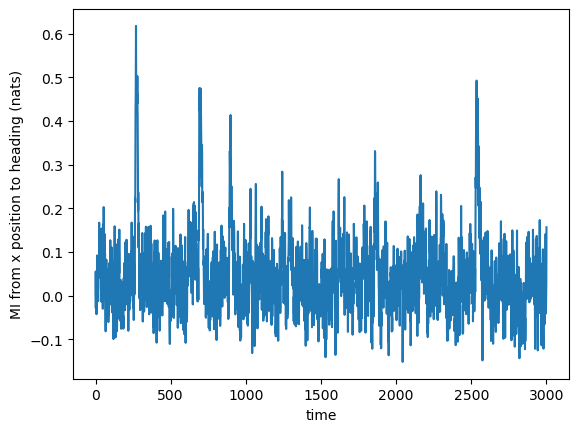

In [4]:
# 1. Construct the calculator:
calcClass = JPackage("infodynamics.measures.continuous.kraskov").MutualInfoCalculatorMultiVariateKraskov2
calc = calcClass()
# 2. Set any properties to non-default values:
# No properties were set to non-default values

misVersusTime = numpy.zeros((positionsx.shape[0])); # There will be one MI for each time step

# Compute for samples taken across all pairs at each time step:
for t in range(positionsx.shape[0]):
    source = JArray(JDouble, 1)(positionsx[t, :].tolist())
    destination = JArray(JDouble, 1)(headings[t, :].tolist())

    # 3. Initialise the calculator for (re-)use:
    calc.initialise()
    # 4. Supply the sample data:
    calc.setObservations(source, destination)
    # 5. Compute the estimate:
    misVersusTime[t] = calc.computeAverageLocalOfObservations()

    # print("MI_Kraskov (KSG) alg. 2(time=%d) = %.4f nats" %\
    #    (t, misVersusTime[t]))

plt.plot(misVersusTime);
plt.xlabel('time');
plt.ylabel('MI from x position to heading (nats)');
# Compare the times of the peaks in MI to when the trails are formed and collapse.
# What is this detecting?

# Analysis 3 -- mutual information averaged over all ant pairs

This sample analysis looks at how the information in x position between all pairs of ants. We use pointwise values to rearrange this to look at how MI between the ants varies with time.

You can see that the MI increases when the ants are making trails, with the largest 3 increases corresponding to when the trails to each food source are being sustained.

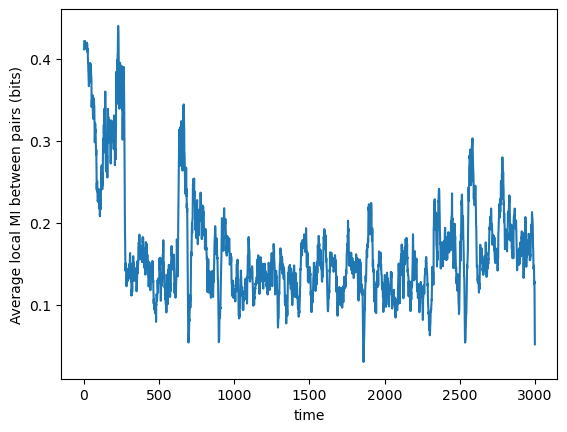

In [5]:
# using positionsx as loaded above

avLocals = numpy.zeros((positionsx.shape[0])); # There will be one average MI across pairs for each time step

# 1. Construct the calculator:
calcClass = JPackage("infodynamics.measures.discrete").MutualInformationCalculatorDiscrete
calc = calcClass(8, 8, 0)
# 2. No other properties to set for discrete calculators.
mUtils = JPackage('infodynamics.utils').MatrixUtils

# Compute for all pairs:
for s in range(positionsx.shape[1]):
    for d in range(positionsx.shape[1]):
        # For each source-dest pair:
        if (s == d):
            continue
        source = mUtils.discretise(JArray(JDouble, 1)(positionsx[:,s].tolist()), 8)
        destination = mUtils.discretise(JArray(JDouble, 1)(positionsx[:,d].tolist()), 8)

        # 3. Initialise the calculator for (re-)use:
        calc.initialise()
        # 4. Supply the sample data:
        calc.addObservations(source, destination)
        # 5. Compute the estimate:
        result = calc.computeAverageLocalOfObservations()

        # print("MI_Binned(col_%d -> col_%d) = %.4f nats" %\
        #    (s, d, result))
        locals = calc.computeLocalFromPreviousObservations(source, destination);
        avLocals = avLocals + locals;

avLocals = avLocals / (positionsx.shape[1]*(positionsx.shape[1]-1)); # Dividing by the number of pairs
plt.plot(avLocals);
plt.xlabel('time');
plt.ylabel('Average local MI between pairs (bits)');